# Gaussian Naive Bayes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

url = "./heart_preprocessed_naive_bayes.csv"
df = pd.read_csv(url)
df.head()

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_High,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_High,stress_level_Low,stress_level_Moderate,EKG_results_Abnormal,EKG_results_Normal
0,-0.128624,-0.65012,-0.495922,-1.030985,1.733857,0.346252,-0.645920,0.637962,0.435961,0.949813,...,0,1,0,0,1,0,0,1,1,0
1,-0.632521,1.53810,-0.495922,0.796421,-0.576720,0.407729,1.548102,-2.408741,0.635528,-2.056956,...,0,1,0,0,1,0,1,0,0,1
2,-1.136418,-0.65012,-0.495922,-1.005952,1.733857,2.375001,-0.645920,-0.052421,-1.293620,0.749362,...,0,1,1,0,0,0,1,0,0,1
3,1.802981,1.53810,-0.495922,1.972970,-0.576720,-1.129202,-0.645920,1.480362,-0.029696,0.248234,...,0,1,0,0,1,0,0,1,0,1
4,1.215101,-0.65012,-0.495922,-0.154831,-0.576720,-0.883293,-0.645920,-0.657710,-0.029696,-1.154925,...,0,1,1,0,0,0,1,0,0,1


In [2]:
X = df.drop(columns=["heart_attack"], axis = 1).values
y = df["heart_attack"].values.astype(np.int8)

print(X.shape)
print(y.shape)
print(f"Dataset: {X.shape}  |  positives {(y==1).sum()}")

(20000, 42)
(20000,)
Dataset: (20000, 42)  |  positives 7896


In [3]:
# Train on data. No parameters to adjust
from sklearn.naive_bayes import GaussianNB       ### Because continuous data
from sklearn.model_selection import (
    StratifiedKFold, 
    cross_val_score, 
    train_test_split
)
import sklearn.neighbors as nb

# OBS: deleted 'random_state' parameter since its use is no longer needed
cv = StratifiedKFold(
    n_splits = 10, 
) 

gnb = GaussianNB()
cv_scores = cross_val_score(
    gnb,
    X = X,
    y = y,
    cv = cv
)
np.mean(cv_scores)  # Mean score of the executions

np.float64(0.71735)

In [4]:
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score, confusion_matrix

predicted = cross_val_predict(
    estimator = GaussianNB(), 
    X = X,
    y = y,  
    cv = cv
)  

print(confusion_matrix(y, predicted))  # Confusion matrix
print(accuracy_score(y, predicted))    # Accuracy compute using both, true value and prediction

[[9320 2784]
 [2869 5027]]
0.71735


In [5]:
from sklearn.metrics import classification_report

print(classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77     12104
           1       0.64      0.64      0.64      7896

    accuracy                           0.72     20000
   macro avg       0.70      0.70      0.70     20000
weighted avg       0.72      0.72      0.72     20000



***
## Adjusting probability threshold

In [6]:
# Focus on predict class 1
y2 = y.copy()  # Since data is already in 0s and 1s, just make a copy

# Split the data
(X_train, X_test, y_train, y_test) = train_test_split(X, y2, test_size=0.3, random_state=1)


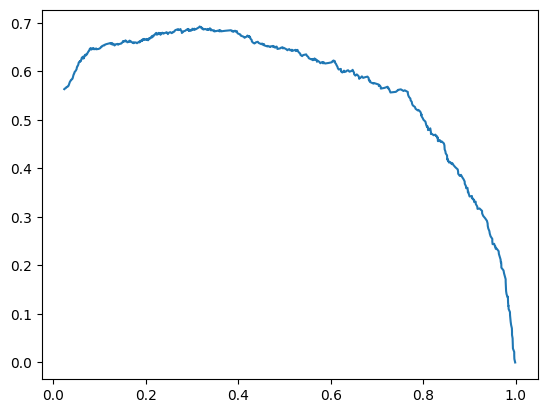

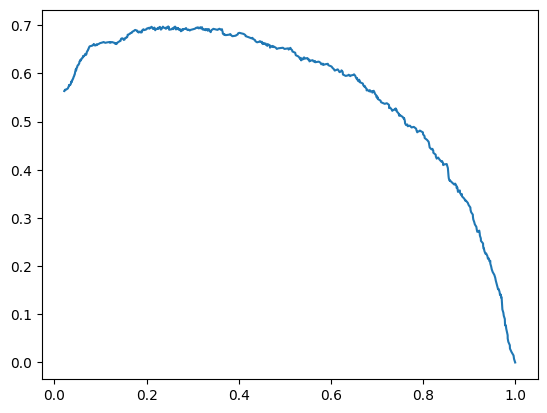

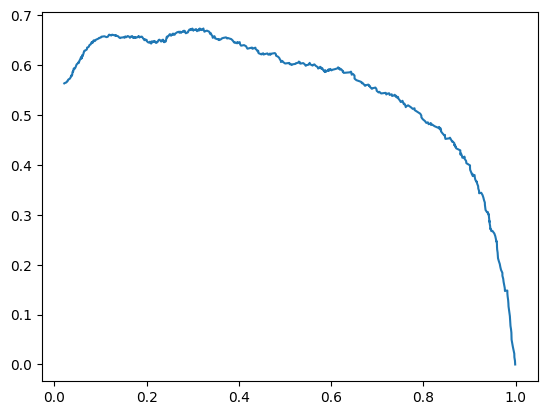

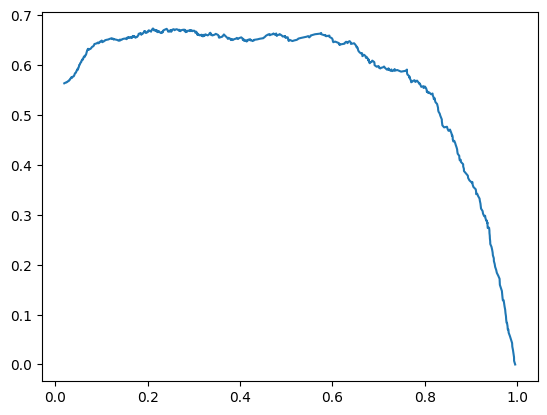

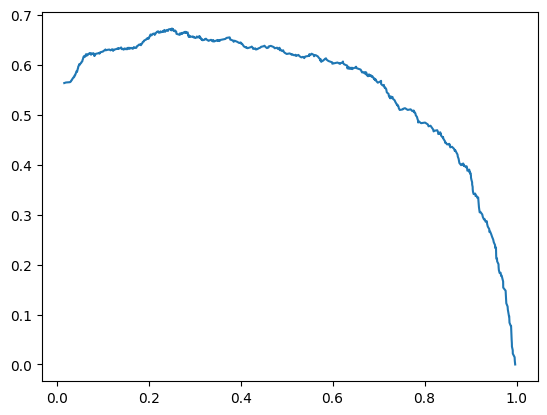

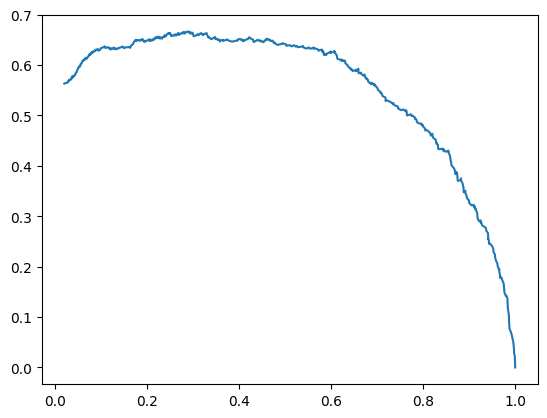

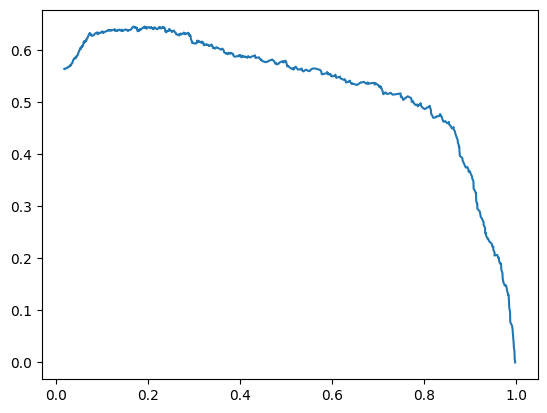

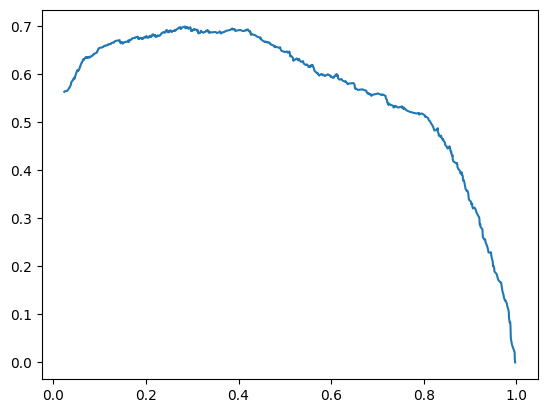

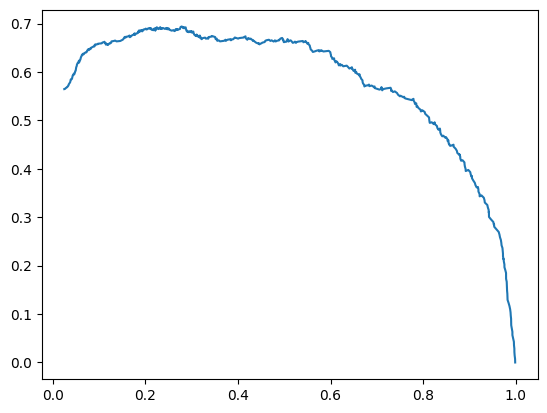

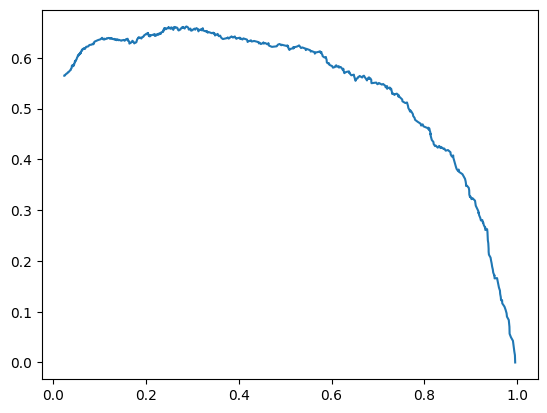

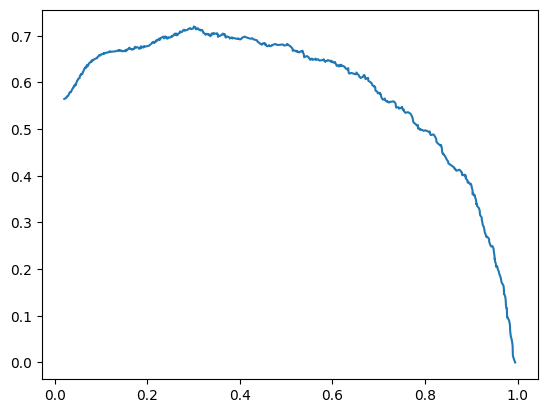

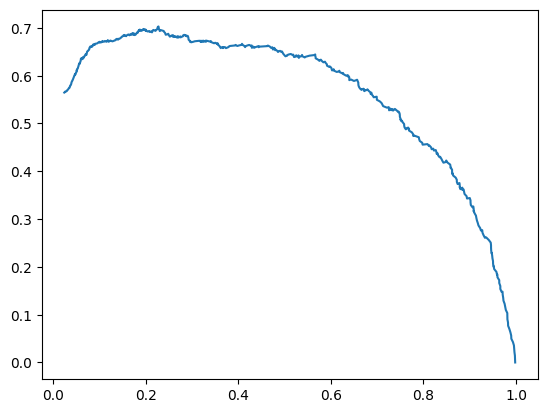

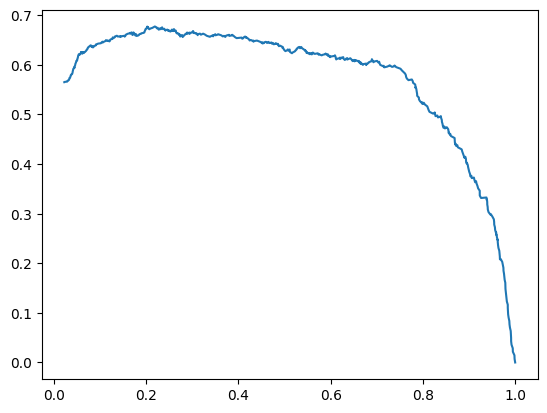

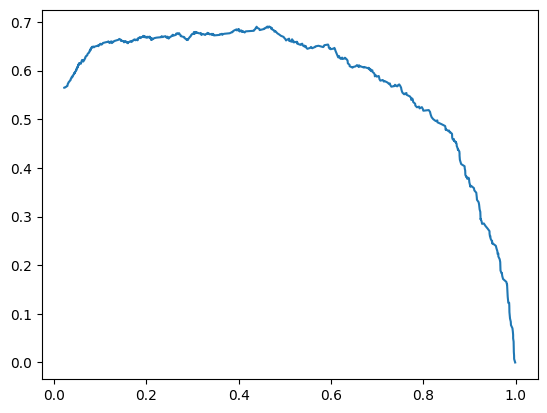

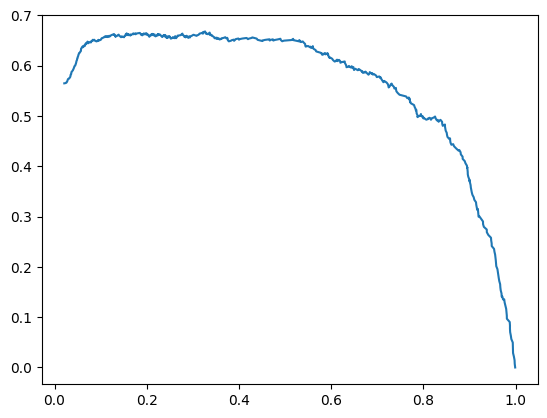

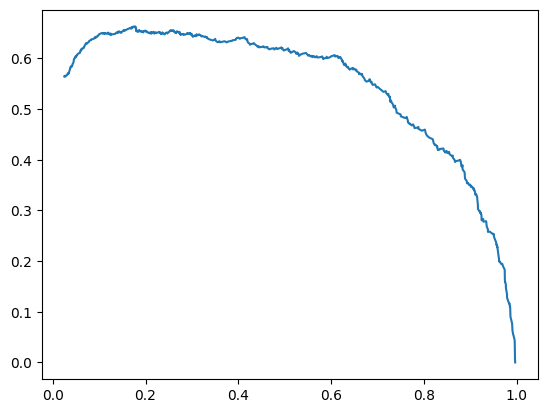

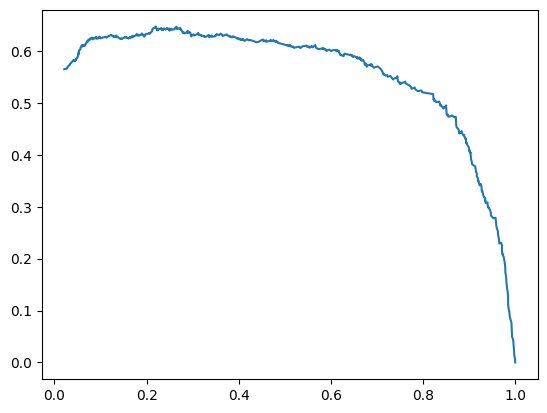

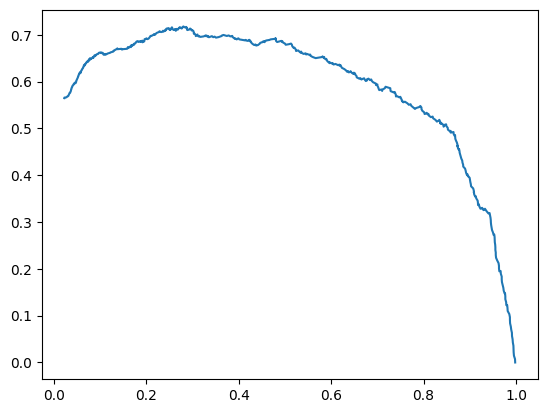

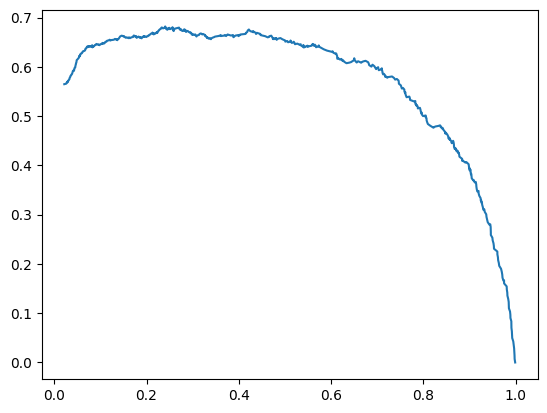

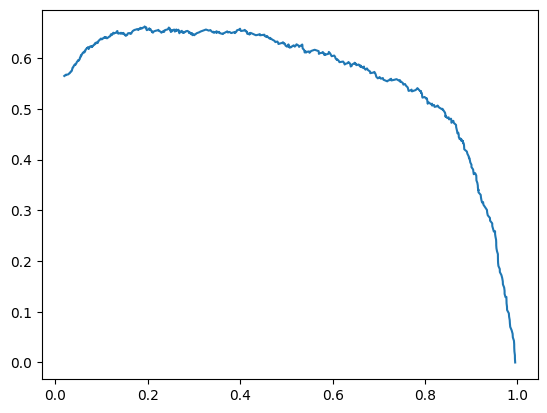

Selected threshold in 10-fold cross validation: 0.265184


In [7]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def filterp(th,ProbClass1):
    """Given a threshold "th" and a set of probabilities of belonging to class 1 "ProbClass1", 
    return predictions.""" 
    y = np.zeros(ProbClass1.shape[0])
    for i,v in enumerate(ProbClass1):
        if ProbClass1[i]>th:
            y[i]=1
    return y  

clf = GaussianNB()
lth=[]

# We do a 10-fold cross-validation with 10 iterations
kf = StratifiedKFold(
    n_splits = 20, 
    shuffle = True, 
    random_state = 42
)

# Now we compute the threshold by iterating the data we have
for train_index, test_index in kf.split(X_train, y_train):
    # Use X_train instead of X
    X_train2, X_test2 = X_train[train_index], X_train[test_index]
    y_train2, y_test2 = y_train[train_index], y_train[test_index]
    
    clf.fit(X_train2, y_train2)
    probs = clf.predict_proba(X_test2)
    ProbClass1 = probs[:,1]  # This should work now as GaussianNB always returns probabilities for both classes
    
    # Sort probabilities and generate pairs (threshold, f1-for-that-threshold)
    res = np.array([[th,f1_score(y_test2,filterp(th,ProbClass1),pos_label=1)] for th in np.sort(ProbClass1)])
    
    # Uncomment the following lines if you want to plot at each iteration how f1-score
    # evolves increasing the threshold 
    plt.plot(res[:,0],res[:,1])
    plt.show()

    # Find the threshold that has maximum value of f1-score
    maxF = np.max(res[:,1])
    pl = np.argmax(res[:,1])
    optimal_th = res[pl,0]
    
    # Store the optimal threshold found for the current iteration
    lth.append(optimal_th)

# Compute the average threshold for all 10 iterations    
threshold = np.mean(lth)
print(f"Selected threshold in 10-fold cross validation: {np.round(threshold, 6)}")

In [8]:
# Train a classifier with the whole training data 
clf = GaussianNB()
clf.fit(X_train, y_train)

# Obtain probabilities for data on test set
probs = clf.predict_proba(X_test)

# Generate predictions using probabilities and threshold found on 10 folds cross-validation
prediction = filterp(threshold,probs[:,1])

print(classification_report(y_test, prediction))
# Ignore warnings explaining that in some iterations f1 score is 0

              precision    recall  f1-score   support

           0       0.82      0.59      0.68      3596
           1       0.57      0.81      0.67      2404

    accuracy                           0.68      6000
   macro avg       0.69      0.70      0.68      6000
weighted avg       0.72      0.68      0.68      6000



In [9]:
clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      3596
           1       0.65      0.62      0.64      2404

    accuracy                           0.72      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.71      0.72      0.71      6000

